# Advanced Statistical Visualisations with Statistical API

### Python Library Imports

In [1]:
# Utilities
import os
import getpass
import warnings
from typing import (
    Optional,
    Tuple,
    Any
)
warnings.filterwarnings('ignore', category=UserWarning)  # Suppress specific warnings

# Data Manipulation
import pandas as pd
import geopandas as gpd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pywaffle import Waffle
import contextily as cx

# Geospatial and Interpolation
from scipy.interpolate import interp1d
import rasterio

# Sentinel Hub
from sentinelhub import (
    SHConfig,
    DataCollection,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    SentinelHubStatistical,
    SentinelHubStatisticalDownloadClient,
    BBox,
    CRS,
    MimeType,
    Geometry,
    parse_time
)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Helper Functions

In [2]:
# Helper Utility Functions

# define functions to extract statistics for all acquisition dates
def extract_stats(date, stat_data):
    d = {}
    for key, value in stat_data['outputs'].items():
        stats = value['bands']['B0']['stats']
        if stats['sampleCount']==stats['noDataCount']:
            continue
        else:
            d['date'] = [date]
            for stat_name, stat_value in stats.items():
                if (stat_name=='sampleCount' or stat_name=='noDataCount'):
                    continue
                else:
                    d[f'{key}_{stat_name}'] = [stat_value]
    return pd.DataFrame(d)

def read_acquisitions_stats(stat_data):
    df_li = []
    for aq in stat_data:
        date = aq['interval']['from'][:10]
        df_li.append(extract_stats(date, aq))
    return pd.concat(df_li)

def stats_to_df(stats_data):
    """Transform Statistical API response into a pandas.DataFrame"""
    df_data = []

    for single_data in stats_data["data"]:
        df_entry = {}
        is_valid_entry = True

        df_entry["interval_from"] = parse_time(single_data["interval"]["from"]).date()
        df_entry["interval_to"] = parse_time(single_data["interval"]["to"]).date()

        for output_name, output_data in single_data["outputs"].items():
            for band_name, band_values in output_data["bands"].items():
                band_stats = band_values["stats"]
                if band_stats["sampleCount"] == band_stats["noDataCount"]:
                    is_valid_entry = False
                    break

                for stat_name, value in band_stats.items():
                    col_name = f"{output_name}_{band_name}_{stat_name}"
                    if stat_name == "percentiles":
                        for perc, perc_val in value.items():
                            perc_col_name = f"{col_name}_{perc}"
                            df_entry[perc_col_name] = perc_val
                    else:
                        df_entry[col_name] = value

        if is_valid_entry:
            df_data.append(df_entry)

    return pd.DataFrame(df_data)

## Credentials

Credentials for Sentinel Hub services (`client_id` & `client_secret`) can be obtained in your [Dashboard](https://shapps.dataspace.copernicus.eu/dashboard/#/). In the User Settings you can create a new OAuth Client to generate these credentials. For more detailed instructions, visit the relevant [documentation page](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Overview/Authentication.html).

Now that you have your `client_id` & `client_secret`, it is recommended to configure a new profile in your Sentinel Hub Python package. Instructions on how to configure your Sentinel Hub Python package can be found [here](https://sentinelhub-py.readthedocs.io/en/latest/configure.html). Using these instructions you can create a profile specific to using the package for accessing Copernicus Data Space Ecosystem data collections. This is useful as changes to the the config class are usually only temporary in your notebook and by saving the configuration to your profile you won't need to generate new credentials or overwrite/change the default profile each time you rerun or write a new Jupyter Notebook. 

If you are a first time user of the Sentinel Hub Python package for Copernicus Data Space Ecosystem, you should create a profile specific to the Copernicus Data Space Ecosystem. You can do this in the following cell:

In [3]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")

However, if you have already configured a profile in Sentinel Hub Python for the Copernicus Data Space Ecosystem, then you can run the below cell entering the profile name as a string replacing `<profile_name>`.

In [4]:
config = SHConfig("cdse")

## 6. How to plot a spectral signature plot for a field of interest

As well as creating time series with Statistical API, we can also derive more simple analyses like a spectral signature plot using the API output. This can be useful if you want to compare the spectral response of different land cover types. For this example, let's compare the spectral signature of four polygons; one will be urban, the second forest, the third grassland, and fourth terrestrial water. Firstly, let's build the evalscript.

### Creating a field of interest

For this example we have created some fields of interests for the different land cover types in and around Zurich, Switzerland. We will use Sentinel-2 L2A to create the spectral signature plot.

In [5]:
land_cover_samples="""{
"type": "FeatureCollection",
"name": "zurich_landcover",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.539461050474173, 47.347751085073959 ], [ 8.545030558394702, 47.349820439748108 ], [ 8.557606866602345, 47.350307334939416 ], [ 8.567488251622636, 47.334115661516677 ], [ 8.548444127765348, 47.332532750321199 ], [ 8.539461050474173, 47.347751085073959 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.561020435972992, 47.399825441623598 ], [ 8.575752682730519, 47.395568955189852 ], [ 8.565511974618577, 47.384987056387466 ], [ 8.554013635685875, 47.390947237735197 ], [ 8.561020435972992, 47.399825441623598 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.525921486466855, 47.386606085799173 ], [ 8.534639710587191, 47.382048690811793 ], [ 8.528613879209898, 47.376926576724422 ], [ 8.521049537693726, 47.38035584375195 ], [ 8.525921486466855, 47.386606085799173 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 4 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 8.635924961396981, 47.406133316022533 ], [ 8.643361093734915, 47.4002325161401 ], [ 8.632335104406256, 47.402402004692235 ], [ 8.630924803445613, 47.403963981131589 ], [ 8.635924961396981, 47.406133316022533 ] ] ] ] } }
]
}
"""

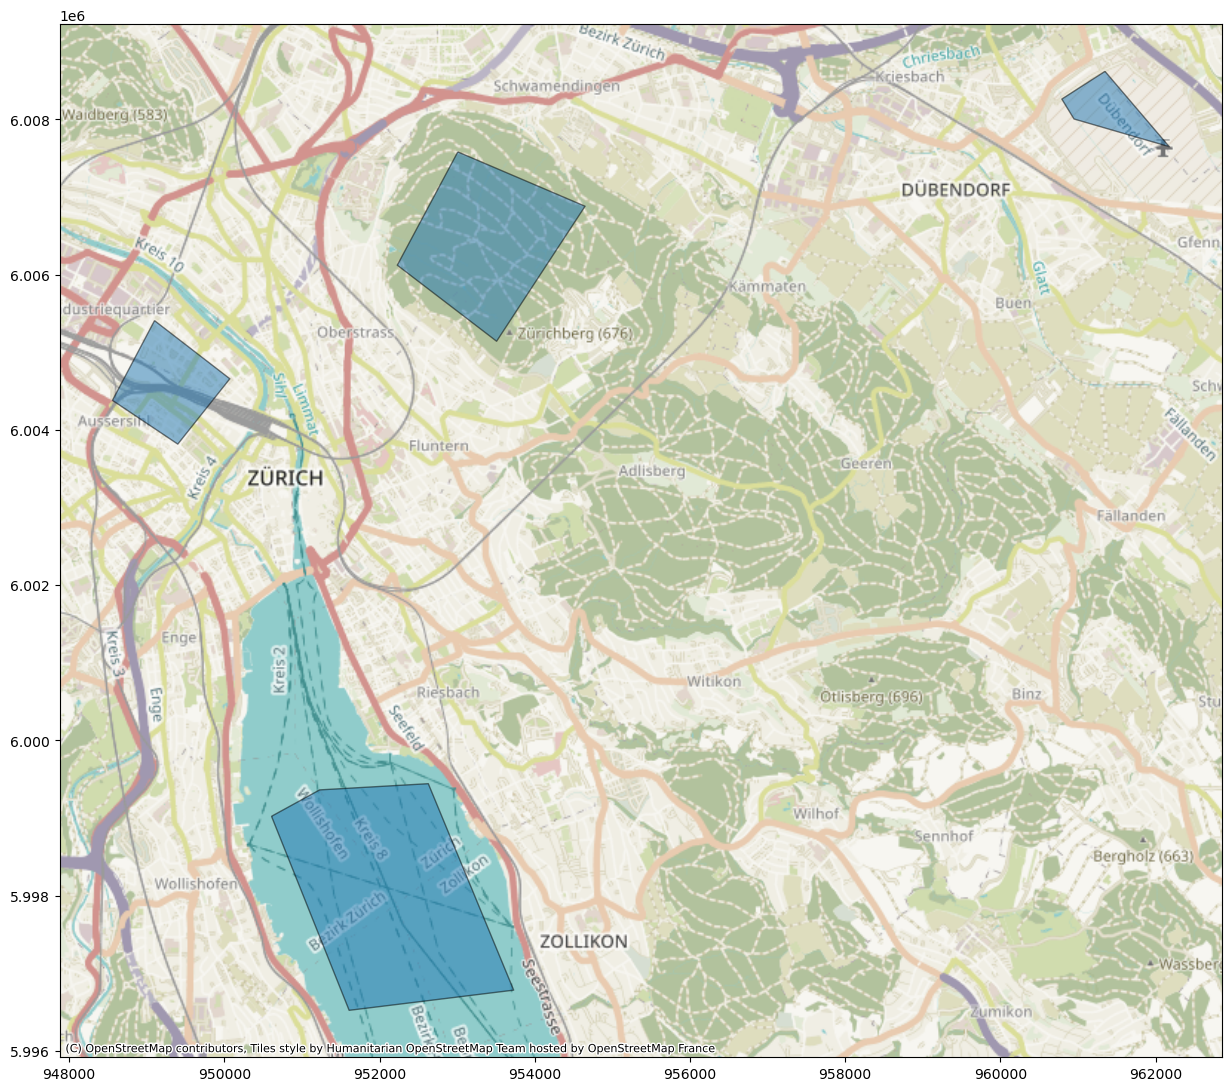

In [6]:
# Read the land cover samples into a GeoDataFrame
lcs_gdf = gpd.read_file(land_cover_samples)

# Calculate the area for each geometry and add it as a new column
lcs_gdf["area"] = lcs_gdf.geometry.area

lcs_gdf_wm = lcs_gdf.to_crs(epsg=3857)

# Explore the GeoDataFrame, visualizing the 'area' column with a specified colormap
ax = lcs_gdf_wm.plot(alpha=0.5, edgecolor="k", figsize = (15,15))
cx.add_basemap(ax)

### The Evalscript

In this evalscript we will extract out statistics for every band from the Sentinel-2 L2A data collection. Each of these must be defined as a seperate output. This makes a long evalscript but actually there is just a lot of repetition here so nothing to worry about.

In [7]:
evalscript = """
//VERSION=3
  function setup() {
    return {
      input: [
        {
          bands: ["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12", "dataMask"],
        },
      ],
      output: [
      {
        id: "B01",
        bands: 1
      },
      {
        id: "B02",
        bands: 1
      },
      {
        id: "B03",
        bands: 1
      },
      {
        id: "B04",
        bands: 1
      },
      {
        id: "B05",
        bands: 1
      },
      {
        id: "B06",
        bands: 1
      },
      {
        id: "B07",
        bands: 1
      },
      {
        id: "B08",
        bands: 1
      },
      {
        id: "B8A",
        bands: 1
      },
      {
        id: "B09",
        bands: 1
      },
      {
        id: "B11",
        bands: 1
      },
      {
        id: "B12",
        bands: 1
      },
      {
        id: "dataMask",
        bands: 1
      }
    ]
  }
}
  
function evaluatePixel(samples) {

    return {
      B01: [10 * samples.B01],
      B02: [10 * samples.B02],
      B03: [10 * samples.B03],
      B04: [10 * samples.B04],
      B05: [10 * samples.B05],
      B06: [10 * samples.B06],
      B07: [10 * samples.B07],
      B08: [10 * samples.B08],      
      B8A: [10 * samples.B8A],
      B09: [10 * samples.B09],
      B11: [10 * samples.B11],
      B12: [10 * samples.B12],      
      dataMask: [samples.dataMask]
    };
    }
"""

### The Request Body

In [8]:
lcs_gdf = gpd.read_file(land_cover_samples)

aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2024-06-19T00:00:00Z', '2024-06-20T00:00:00Z'),
        aggregation_interval='P1D',
        resolution=(0.0001,0.0001),        
    )

input_data = SentinelHubStatistical.input_data(
    DataCollection.SENTINEL2_L2A.define_from("s2l2a", service_url=config.sh_base_url),
    maxcc=0.1,
)

lcs_requests = []

for geo_shape in lcs_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(lcs_gdf.crs)),
        config=config,
    )
    lcs_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [9]:
%%time

# Create a list of download requests from the first item in each lcs_request's download_list
download_requests = [lcs_request.download_list[0] for lcs_request in lcs_requests]

# Initialize the SentinelHubStatisticalDownloadClient with the given configuration
client = SentinelHubStatisticalDownloadClient(config=config)

# Download the statistics using the client and the list of download requests
lcs_stats = client.download(download_requests)

# Output the number of statistics downloaded
len(lcs_stats)

CPU times: user 23.9 ms, sys: 10.7 ms, total: 34.6 ms
Wall time: 1.22 s


4

### Manipulation and Visualisation of our Output

We need to conduct some additional data handling before visualising the output. First, we concatenate the four requests into single pandas dataframe. We then set the index by the `id` column.

In [10]:
# Convert the statistics to DataFrames and assign the 'id' column
lcs_dfs = [
    stats_to_df(polygon_stats).assign(id=id) 
    for polygon_stats, id in zip(lcs_stats, lcs_gdf["id"].values)
]

# Concatenate all DataFrames into a single DataFrame and set 'id' as the index
lcs_df = pd.concat(lcs_dfs).set_index('id')

# Display the resulting DataFrame
lcs_df

,interval_from,interval_to,B11_B0_min,B11_B0_max,B11_B0_mean,B11_B0_stDev,B11_B0_sampleCount,B11_B0_noDataCount,B01_B0_min,B01_B0_max,...,B8A_B0_mean,B8A_B0_stDev,B8A_B0_sampleCount,B8A_B0_noDataCount,B09_B0_min,B09_B0_max,B09_B0_mean,B09_B0_stDev,B09_B0_sampleCount,B09_B0_noDataCount
id,,,,,,,,,,,,,,,,,,,,,
1,2024-06-19,2024-06-20,0.101,0.295,0.120570,0.007851,49840,17097,0.104,0.269,...,0.131961,0.027247,49840,17097,0.058,0.166,0.113769,0.020756,49840,17097
2,2024-06-19,2024-06-20,0.938,2.612,1.881216,0.214331,32116,14697,0.114,0.272,...,4.054901,0.559307,32116,14697,2.845,5.333,4.032868,0.393856,32116,14697
3,2024-06-19,2024-06-20,1.048,3.060,1.889592,0.291348,13192,6161,0.277,1.179,...,1.774202,0.503178,13192,6161,1.110,3.098,1.763265,0.370556,13192,6161
4,2024-06-19,2024-06-20,1.992,3.335,2.414161,0.337002,7316,4172,0.000,0.657,...,4.659402,0.761257,7316,4172,2.617,5.853,4.617151,0.702350,7316,4172


However, this dataframe needs cleaning up. Firstly, we define only the columns we need so only the mean of each band. We then transpose the dataframe, effectively flipping it. Now the `id` column is at the head of the table with the mean band values now as rows, and the fields now as columns.

In [11]:
# Select specific columns from the DataFrame
lcs_df = lcs_df[[
    "B01_B0_mean", "B02_B0_mean", "B03_B0_mean", "B04_B0_mean", 
    "B05_B0_mean", "B06_B0_mean", "B07_B0_mean", "B08_B0_mean", 
    "B8A_B0_mean", "B09_B0_mean", "B11_B0_mean", "B12_B0_mean"
]]

# Transpose the DataFrame to switch rows and columns
lcs_df = lcs_df.transpose()

# Display the resulting DataFrame
lcs_df

id,1,2,3,4
B01_B0_mean,0.183539,0.151341,0.624174,0.274317
B02_B0_mean,0.213967,0.180739,0.702721,0.336133
B03_B0_mean,0.281845,0.445888,0.896901,0.811327
B04_B0_mean,0.121884,0.231310,0.972005,0.569948
B05_B0_mean,0.121390,0.831381,1.204406,1.469895
B06_B0_mean,0.119777,3.040965,1.561291,3.600928
B07_B0_mean,0.129828,3.769644,1.673806,4.239001
B08_B0_mean,0.126008,3.845154,1.677996,4.361113
B8A_B0_mean,0.131961,4.054901,1.774202,4.659402
B09_B0_mean,0.113769,4.032868,1.763265,4.617151


Next, we can insert two additional columns, firstly the central wavelength of each band and the band name. We can then use these in the plot.

In [12]:
# Add 'Band' and 'Wavelength' columns to the DataFrame
lcs_df = lcs_df.assign(
    Band=["Coastal", "Blue", "Green", "Red", "RedEdge1", "RedEdge2", "Rededge3", "NIR", "NarrowNIR", "WaterVapour", "SWIR1", "SWIR2"],
    Wavelength=[442, 492, 559, 664, 704, 740, 782, 833, 864, 945, 1613, 2202]
)

# Display the resulting DataFrame
lcs_df

id,1,2,3,4,Band,Wavelength
B01_B0_mean,0.183539,0.151341,0.624174,0.274317,Coastal,442
B02_B0_mean,0.213967,0.180739,0.702721,0.336133,Blue,492
B03_B0_mean,0.281845,0.445888,0.896901,0.811327,Green,559
B04_B0_mean,0.121884,0.231310,0.972005,0.569948,Red,664
B05_B0_mean,0.121390,0.831381,1.204406,1.469895,RedEdge1,704
B06_B0_mean,0.119777,3.040965,1.561291,3.600928,RedEdge2,740
B07_B0_mean,0.129828,3.769644,1.673806,4.239001,Rededge3,782
B08_B0_mean,0.126008,3.845154,1.677996,4.361113,NIR,833
B8A_B0_mean,0.131961,4.054901,1.774202,4.659402,NarrowNIR,864
B09_B0_mean,0.113769,4.032868,1.763265,4.617151,WaterVapour,945


Finally, we can plot the spectral signature. In addition to connecting the points with a line, we're also using the `interp1D` function from scipy library to add the curves between the points.

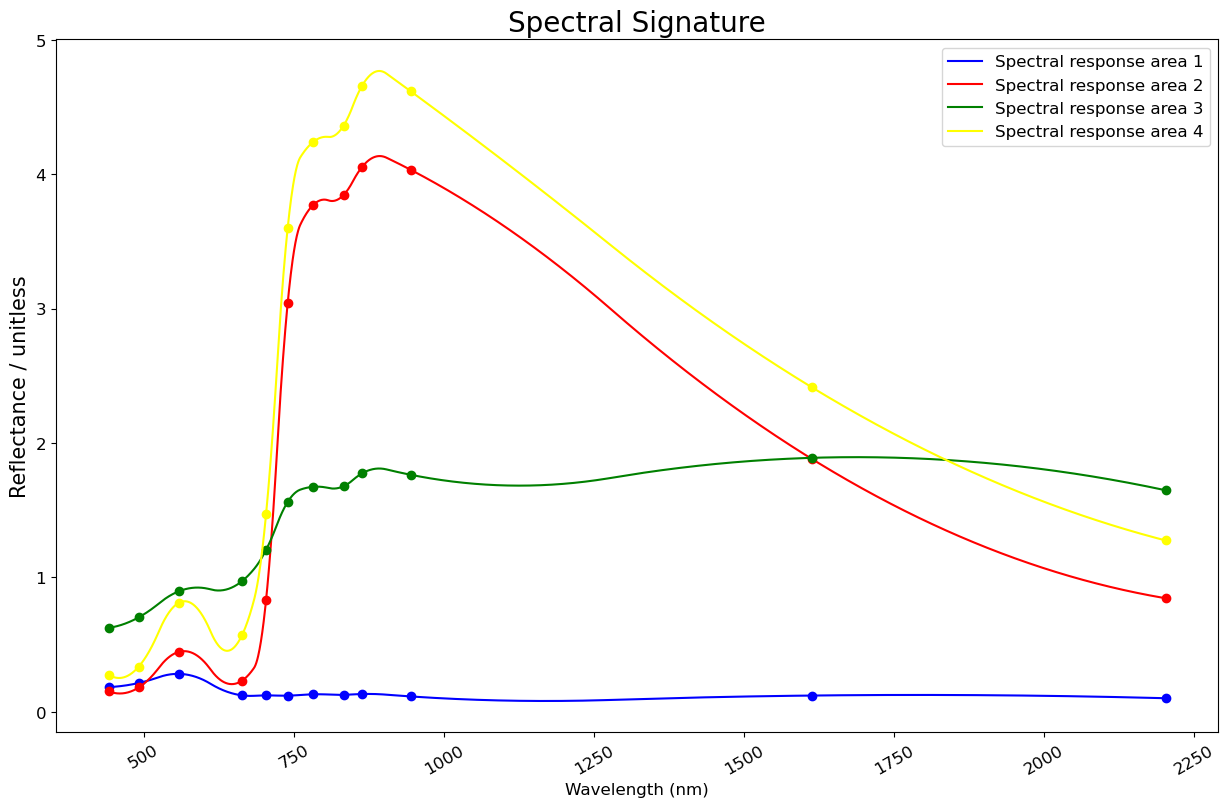

In [13]:
# Create a figure and axis with specified size
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(15, 9))

# Extract spectral values and wavelength
a_spectralvalue = lcs_df[1]
b_spectralvalue = lcs_df[2]
c_spectralvalue = lcs_df[3]
d_spectralvalue = lcs_df[4]
wavelength = lcs_df["Wavelength"]

# Define x and y values for interpolation
x = wavelength
spectral_values = [a_spectralvalue, b_spectralvalue, c_spectralvalue, d_spectralvalue]
colors = ['blue', 'red', 'green', 'yellow']
labels = ['Spectral response area 1', 'Spectral response area 2', 'Spectral response area 3', 'Spectral response area 4']

# Interpolate and plot each spectral value
for i, (y, color, label) in enumerate(zip(spectral_values, colors, labels)):
    fun = interp1d(x=x, y=y, kind=2)
    x2 = np.linspace(start=442, stop=2202, num=2300)
    y2 = fun(x2)
    ax_stat.plot(x2, y2, label=label, color=color)
    ax_stat.plot(x, y, ls='', marker='o', color=color)

# Set tick parameters
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)

# Set labels and title
ax_stat.set_xlabel('Wavelength (nm)', size=12)
ax_stat.set_ylabel('Reflectance / unitless', size=15)
ax_stat.set_title('Spectral Signature', fontsize=20)

# Set legend
ax_stat.legend(loc='upper right', prop={'size': 12})

# Optimize visibility of x-tick labels
for label in ax_stat.get_xticklabels()[0::13]:
    label.set_visible(True)

# Display the plot
plt.show()

Now we can compare the different spectral curves and we can see some distinct signatures for different land cover types. We could of course use spectral libraries to assist us like in the EO Browser application, but for this example we can use our remote sensing knowledge and expertise!
- Area 1 is clearly terrestrial water, with only a small peak in reflectance in the blue and green channels, but overall very little reflectance across the spectrum.
- Areas 2 and 4 are both vegetated land cover with peaks in the NIR and Red Edge parts of the spectrum. Checking the map from earlier, it seems likelier that area 2 is forest as its curve is slightly lower than area 4. This means we can probably guess that area 2 is forest and area 4 is grassland.
- Lastly, area 3 is a sample of Zurich's inner city and the bright response accross the spectrum is a good indicator of built up areas.

Now that we know the land cover types, we can update the plot with appropiate labels and colour choices:

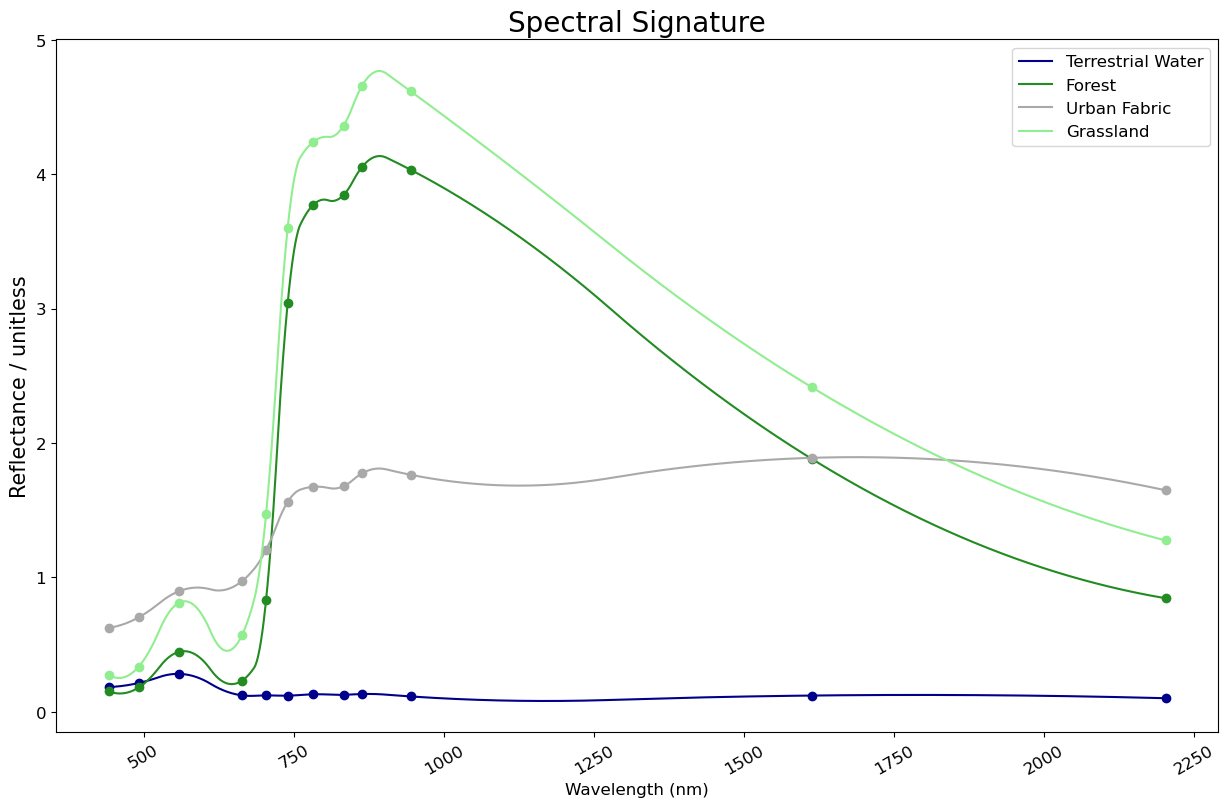

In [14]:
# Create a figure and axis with specified size
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(15, 9))

# Extract spectral values and wavelength
a_spectralvalue = lcs_df[1]
b_spectralvalue = lcs_df[2]
c_spectralvalue = lcs_df[3]
d_spectralvalue = lcs_df[4]
wavelength = lcs_df["Wavelength"]

# Define x and y values for interpolation
x = wavelength
spectral_values = [a_spectralvalue, b_spectralvalue, c_spectralvalue, d_spectralvalue]
colors = ['darkblue', 'forestgreen', 'darkgrey', 'lightgreen']
labels = ['Terrestrial Water', 'Forest', 'Urban Fabric', 'Grassland']

# Interpolate and plot each spectral value
for i, (y, color, label) in enumerate(zip(spectral_values, colors, labels)):
    fun = interp1d(x=x, y=y, kind=2)
    x2 = np.linspace(start=442, stop=2202, num=2300)
    y2 = fun(x2)
    ax_stat.plot(x2, y2, label=label, color=color)
    ax_stat.plot(x, y, ls='', marker='o', color=color)

# Set tick parameters
ax_stat.tick_params(axis='x', labelrotation=30, labelsize=12)
ax_stat.tick_params(axis='y', labelsize=12)

# Set labels and title
ax_stat.set_xlabel('Wavelength (nm)', size=12)
ax_stat.set_ylabel('Reflectance / unitless', size=15)
ax_stat.set_title('Spectral Signature', fontsize=20)

# Set legend
ax_stat.legend(loc='upper right', prop={'size': 12})

# Optimize visibility of x-tick labels
for label in ax_stat.get_xticklabels()[0::13]:
    label.set_visible(True)

# Display the plot
plt.show()

## 7. How to create a Histogram & Box Plot of a certain band's values for a field of interest

Histograms and Box Plots are also useful for analysis of the distribution of pixel values in a field of interest. In this example, we are using Processing API to calculate the NDVI. We then plot the distribution of NDVI values in a histogram and a simple box plot.

### Creating a field of interest

Firstly, we will define some fields of interest in France for the first few examples. Our fields of interest and the time period we are using coincides with the temporal and spatial extent of the [PlanetScope](https://collections.sentinel-hub.com/planetscope/sandbox-data.html) dataset within the Planet Sandbox Data Collection. We will use the [Sentinel-2 L2A](https://docs.sentinel-hub.com/api/latest/data/sentinel-2-l2a/) data collection in the first examples though.

In [ ]:
fields="""{
"type": "FeatureCollection",
"name": "french_fields",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.018730388794967, 48.31900866284024 ], [ 3.02416040226223, 48.319921908340902 ], [ 3.024582971403651, 48.318306155176266 ], [ 3.019491013249525, 48.317392880750582 ], [ 3.018730388794967, 48.31900866284024 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.014150362764628, 48.311958271928731 ], [ 3.012550141917608, 48.312082666515273 ], [ 3.009640649468477, 48.312428205442302 ], [ 3.009328918134642, 48.314653420076148 ], [ 3.015334941833203, 48.314529031756756 ], [ 3.015272595566436, 48.314072938657887 ], [ 3.01566745525596, 48.313603020291822 ], [ 3.016311700012554, 48.313091633623024 ], [ 3.016914380591302, 48.312911956009131 ], [ 3.017142983569447, 48.312566420357946 ], [ 3.016789688057767, 48.312372919371228 ], [ 3.015064774677212, 48.312013558449088 ], [ 3.014150362764628, 48.311958271928731 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.018867896950004, 48.310686665428022 ], [ 3.016685777613156, 48.30872390623729 ], [ 3.013339861296657, 48.311115145071334 ], [ 3.014025670231094, 48.311875342035918 ], [ 3.015542762722426, 48.311972093564449 ], [ 3.016290917923631, 48.311225719879126 ], [ 3.017371586547594, 48.311502155850299 ], [ 3.018285998460177, 48.310838707003604 ], [ 3.018867896950004, 48.310686665428022 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 4 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 2.991995616868946, 48.313513412817962 ], [ 2.996665005881652, 48.314890448089699 ], [ 2.997045318108931, 48.314595372231501 ], [ 2.997953841762987, 48.314258140589665 ], [ 2.998756723131687, 48.313710134417846 ], [ 2.993073168179571, 48.312094184517214 ], [ 2.991995616868946, 48.313513412817962 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 5 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.005412187109072, 48.316379852565653 ], [ 3.005496700937356, 48.313583670619266 ], [ 3.003341598316108, 48.314412705368852 ], [ 3.002242918548413, 48.314763987216573 ], [ 3.001313266437286, 48.314862345700547 ], [ 3.000785055010509, 48.315059062099621 ], [ 3.004165608141879, 48.315958327408346 ], [ 3.005412187109072, 48.316379852565653 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 6 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 2.994681699890837, 48.308712715603669 ], [ 2.994697906481011, 48.308691157048038 ], [ 2.994924798743444, 48.308259984022804 ], [ 2.994973418513966, 48.307559320087115 ], [ 2.991083836872255, 48.307483863397216 ], [ 2.990630052347389, 48.30864803990945 ], [ 2.994681699890837, 48.308712715603669 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 7 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ 3.001245368911225, 48.311019428435152 ], [ 2.994519633989099, 48.308971417560947 ], [ 2.993352759496587, 48.310577496200999 ], [ 3.000175733959753, 48.312539214953759 ], [ 3.000775377796184, 48.31147213553583 ], [ 3.001002270058617, 48.311213446255813 ], [ 3.001245368911225, 48.311019428435152 ] ] ] ] } }
]
}
"""

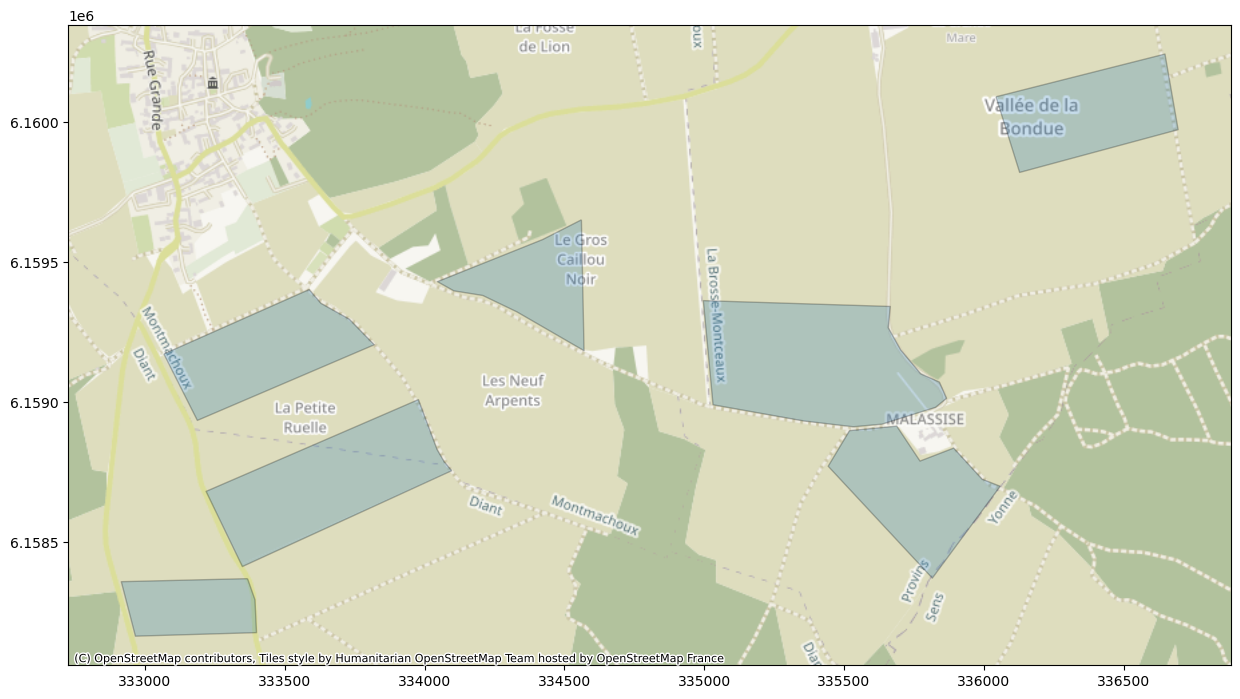

In [ ]:
fields_gdf = gpd.read_file(fields)
fields_gdf["area"] = fields_gdf.geometry.area

fields_gdf_wm = fields_gdf.to_crs(epsg=3857)

# Explore the GeoDataFrame, visualizing the 'area' column with a specified colormap
ax = fields_gdf_wm.plot(alpha=0.25, edgecolor="k", figsize = (15,15))
cx.add_basemap(ax)

### The Evalscript

In [ ]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    if (samples.dataMask == 0){
        return [NaN]
    }
    let val = index(samples.B08, samples.B04);
    return [val];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 1,
      sampleType: "FLOAT32"
    }
  }
}
"""

### The Request Body

In [ ]:
fields_gdf = gpd.read_file(fields)
fields_gdf = fields_gdf.to_crs(epsg=3857)

geometry = Geometry(geometry=fields_gdf.geometry.iloc[0], crs=CRS.POP_WEB)
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2024-09-03', '2024-10-03'),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
    geometry=geometry,
    resolution=(10,10),        
    config=config
)

response = request.get_data()

### Manipulation and Visualisation of our Output

Firstly, let's convert our response into a numpy array.

In [ ]:
# converting list to array
arr = np.array(response)

type(arr)

numpy.ndarray

We can then simply flatten the array and plot the distribution of values using Matplotlib. You change the number of bins (columns) in the histogram if you like in the following example.

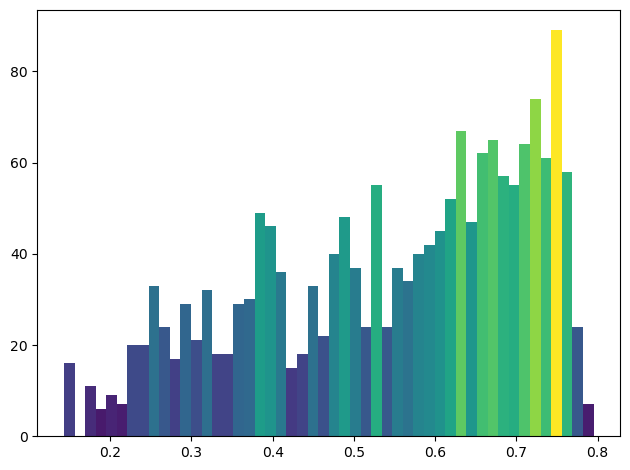

In [ ]:
# Flatten the array
dist1 = arr.flatten()

# Create a figure and axis with tight layout
fig, axs = plt.subplots(1, 1, tight_layout=True)

# N is the count in each bin, bins is the lower-limit of the bin
N, bins, patches = axs.hist(dist1, bins=50)

# We'll color code by height, but you could use any scalar
fracs = N / N.max()

# we need to normalize the data to 0..1 for the full range of the colormap
norm = mcolors.Normalize(fracs.min(), fracs.max())

# Now, we'll loop through our objects and set the color of each accordingly
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)


With the same data, we can also very easily create a box plot with the following:

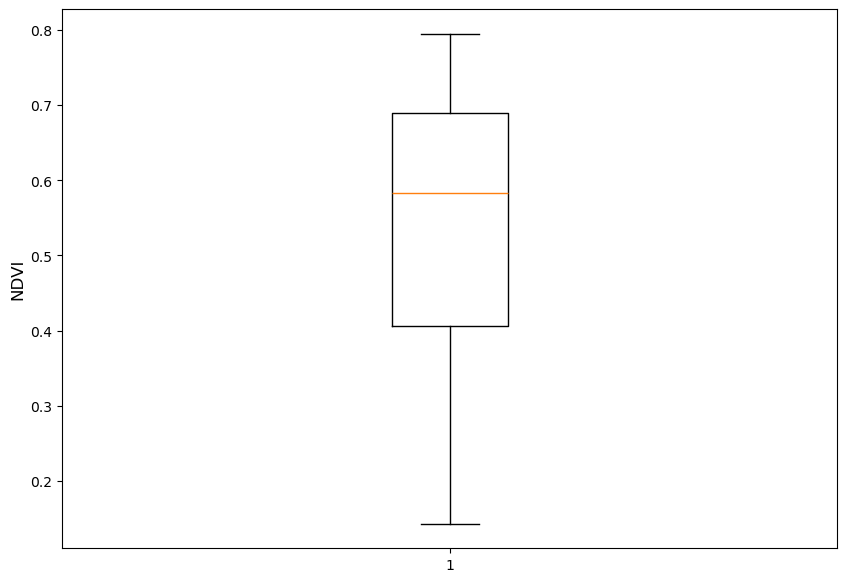

In [ ]:
# Filter out NaN values from the numpy array
filtered_data = dist1[~np.isnan(dist1)]

# Create a figure with specified size
fig = plt.figure(figsize=(10, 7))

# Create a boxplot of the filtered data
plt.boxplot(filtered_data)

# Set labels and title

plt.ylabel('NDVI', size=12)

# Show the plot
plt.show()

## 8. Plotting and styling multiple box plots to compare different land cover types

Let's take this a step further and compare the four land cover types from our previous example in and around Zurich. 

### The Evalscript

In [ ]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    if (samples.dataMask == 0){
        return [NaN]
    }
    let val = index(samples.B08, samples.B04);
    return [val];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 1,
      sampleType: "FLOAT32"
    }
  }
}
"""

### The Request Body

In [ ]:
lcs_gdf = gpd.read_file(land_cover_samples)

lcs_requests = []

for geo_shape in lcs_gdf.geometry.values:
    request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2024-09-03', '2024-10-03'),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
        geometry=Geometry(geo_shape, crs=CRS(lcs_gdf.crs)),
        resolution=(0.0002,0.0002),        
        config=config,
    )
    lcs_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [ ]:
%%time

download_requests = [lcs_request.download_list[0] for lcs_request in lcs_requests]

client = SentinelHubDownloadClient(config=config)

lcs_stats = client.download(download_requests)

len(lcs_stats)

CPU times: user 450 ms, sys: 8.23 ms, total: 458 ms
Wall time: 547 ms


4

### Manipulation and Visualisation of our Output

In this cell we convert all four request outputs into numpy arrays, flatten the arrays and filter out NaN values. We can then plot them as box plots on the same plot. To make best use of the space, we flip them so the band distribution is on the x axis rather than the y axis in the first example.

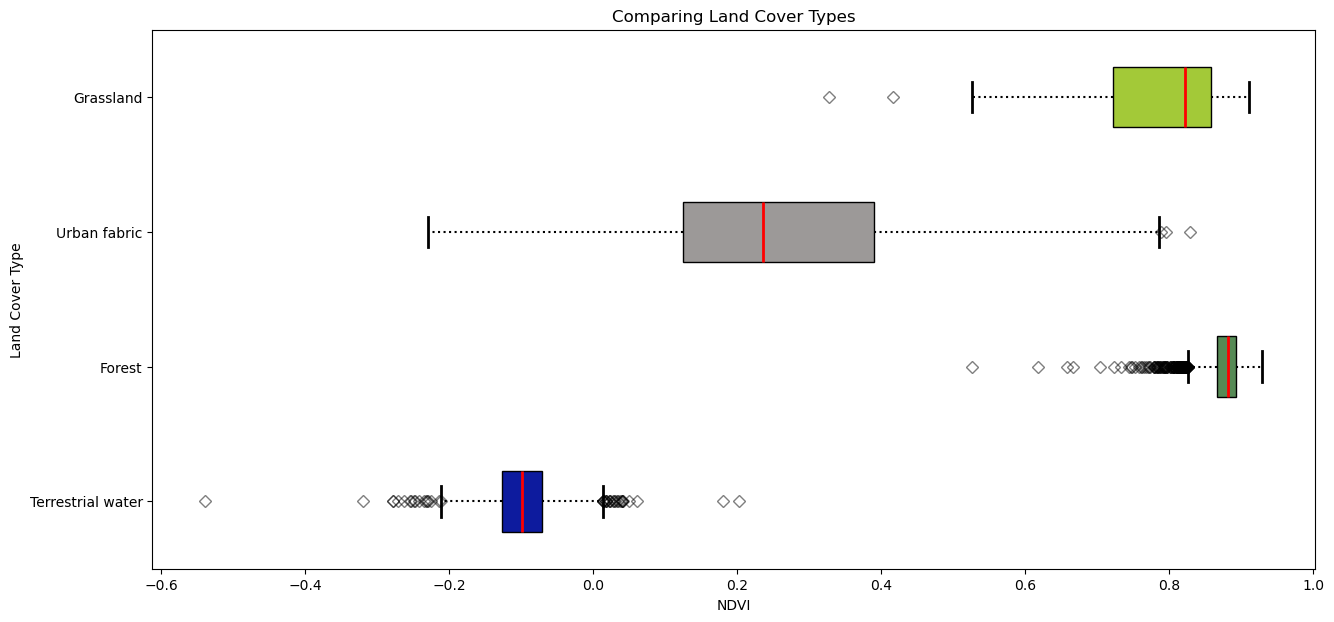

In [ ]:
# Convert list to array and flatten, then filter out NaN values
arrays = [np.array(lcs_stats[i]).flatten() for i in range(4)]
filtered_data = [arr[~np.isnan(arr)] for arr in arrays]

# Creating dataset
data = filtered_data

# Create a figure with specified size
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(111)

# Create boxplot
bp = ax.boxplot(data, patch_artist=True, vert=0)

# Define colors for the boxplot
colors = ['#0d1b9e', '#568a55', '#9c9998', '#a3c938']

# Set face color for each box
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Change color and linewidth of whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#000000', linewidth=1.5, linestyle=":")

# Change color and linewidth of caps
for cap in bp['caps']:
    cap.set(color='#000000', linewidth=2)

# Change color and linewidth of medians
for median in bp['medians']:
    median.set(color='red', linewidth=2)

# Change style of fliers
for flier in bp['fliers']:
    flier.set(marker='D', color='#000000', alpha=0.5)

# Set y-axis labels
ax.set_yticklabels(['Terrestrial water', 'Forest', 'Urban fabric', 'Grassland'])

# Add title
plt.title("Comparing Land Cover Types")
plt.xlabel('NDVI')
plt.ylabel('Land Cover Type')

# Remove top and right axes ticks
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()

# Show plot
plt.show()

## 9. Creating a scatter plot comparing two spectral bands

Scatter plots are also useful tools when you are classifying certain land cover types. You can compare the distribution of pixel values of different land cover types with a band/index in each of the x and y axes. In this example, we use Processing API to download 4 land cover types from in and around Zurich. We then manipulate the data to then plot the Red and NIR bands to analyse the distribution of pixel values between the different land cover types.

### The Evalscript

In [ ]:
evalscript = """
//VERSION=3

function evaluatePixel(samples) {
    if (samples.dataMask == 0){
        return [NaN, NaN]
    }
    return [samples.B04, samples.B08];
}

function setup() {
  return {
    input: [{
      bands: [
        "B04",
        "B08",
        "dataMask"
      ]
    }],
    output: {
      bands: 2,
      sampleType: "FLOAT32"
    }
  }
}
"""

### The Request Body

In [ ]:
lcs_gdf = gpd.read_file(land_cover_samples)

lcs_requests = []

for geo_shape in lcs_gdf.geometry.values:
    request = SentinelHubRequest(
    data_folder="test_dir",    
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,          
            time_interval=('2024-09-03', '2024-10-03'),
            other_args={"dataFilter": {"mosaickingOrder": "leastCC"}}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.TIFF),
    ],
        geometry=Geometry(geo_shape, crs=CRS(lcs_gdf.crs)),
        resolution=(0.00002, 0.00002),
        config=config,
    )
    lcs_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [ ]:
%%time

download_requests = [lcs_request.download_list[0] for lcs_request in lcs_requests]

client = SentinelHubDownloadClient(config=config).download(download_requests, max_threads=5)

lcs_stats = (download_requests)

len(lcs_stats)

CPU times: user 76.8 ms, sys: 14.5 ms, total: 91.3 ms
Wall time: 23.7 ms


4

In [ ]:
# List comprehension to find all .tiff files in the specified data folder
files = [
    os.path.join(folder, filename)
    for folder, _, filenames in os.walk(download_requests[0].data_folder)
    for filename in filenames if filename.endswith(".tiff")
]

# Display the list of files
files

['test_dir/728af0f61cf8863e3727d7e05ba01e04/response.tiff',
 'test_dir/fa787c0851639619fc1d01681b78fd72/response.tiff',
 'test_dir/a92b95fd924c1cb84222edb9ac2e48e3/response.tiff',
 'test_dir/dd84191151a606534f9da6936aa80829/response.tiff']

### Manipulation and Visualisation of our Output

Firstly, we open the the saved images using rasterio and then read each band indivdually. We can very quickly plot the pixel values onto a scatter plot. It looks like the majority of pixels for this land cover type are very tightly clustered around low Red and NIR values.

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


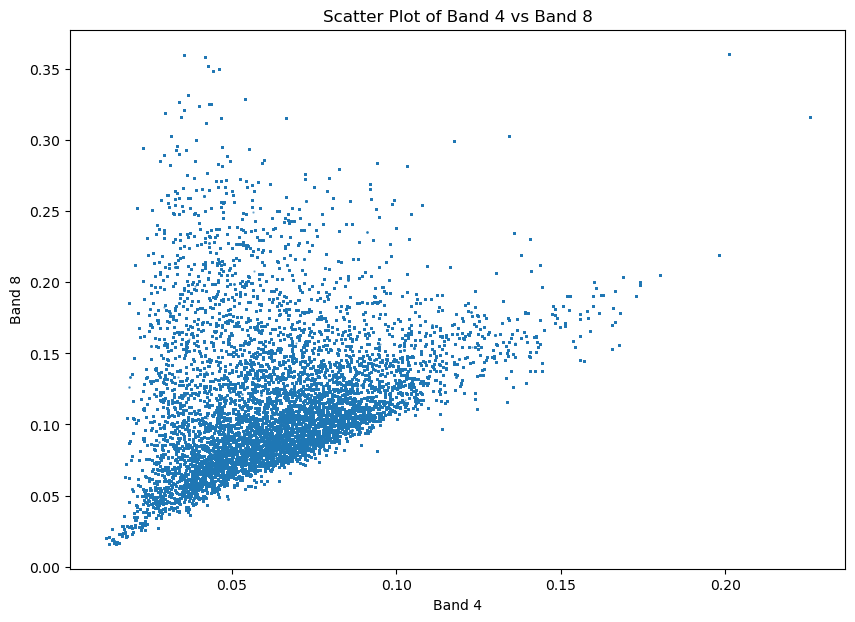

In [ ]:
# Open the .tiff files using rasterio
combined_data = [rasterio.open(file) for file in files[:4]]

# Read the first and second bands from the second file
B4 = combined_data[1].read(1)
B8 = combined_data[1].read(2)

# Create a scatter plot of the bands
plt.figure(figsize=(10, 7))
plt.scatter(B4, B8, s=0.5, alpha=0.5)
plt.xlabel('Band 4')
plt.ylabel('Band 8')
plt.title('Scatter Plot of Band 4 vs Band 8')
plt.show()

Let's go further and plot the scatter plots for all four fields of interest. As we already know the land cover types we can also label and style the plot appropriately. The result shows that the four fields of interest have distinct pixel value distributions when comparing the Red and NIR bands. 

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


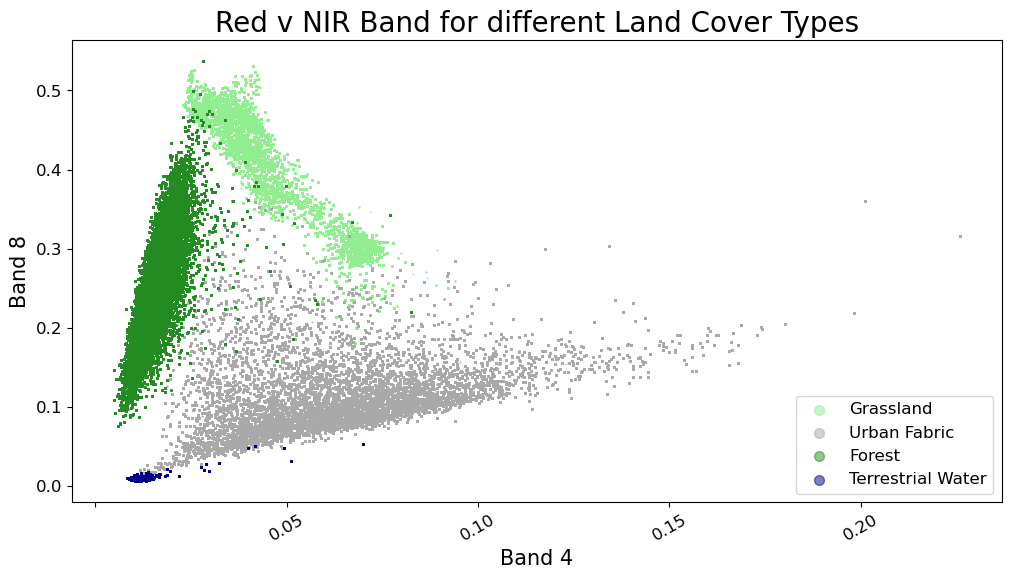

In [ ]:
# Create a figure and axis with specified size
fig_stat, ax_stat = plt.subplots(1, 1, figsize=(12, 6))

# Define labels and colors for each dataset
labels = ['Grassland', 'Urban Fabric', 'Forest', 'Terrestrial Water']
colors = ['lightgreen', 'darkgrey', 'forestgreen', 'darkblue']

# Read the bands and plot the scatter plots
for i, (label, color) in enumerate(zip(labels, colors)):
    arr_B4 = combined_data[i].read(1)
    arr_B8 = combined_data[i].read(2)
    ax_stat.scatter(arr_B4, arr_B8, s=0.5, alpha=0.5, label=label, color=color)

# Set tick parameters
ax_stat.tick_params(axis="x", labelrotation=30, labelsize=12)
ax_stat.tick_params(axis="y", labelsize=12)

# Set labels and title
ax_stat.set_xlabel("Band 4", size=15)
ax_stat.set_ylabel("Band 8", size=15)
ax_stat.set_title("Red v NIR Band for different Land Cover Types", fontsize=20)

# Set legend
ax_stat.legend(loc="lower right", prop={"size": 12}, markerscale=10.)

# Optimize visibility of x-tick labels
for label in ax_stat.get_xticklabels()[1::20]:
    label.set_visible(False)

# Display the plot
plt.show()

## 10. Creating Chloropeth maps based on your Statistical API inputs and outputs in Geopandas

In this final example, we will run Statistical API on several fields and extract the mean NDVI for the fields of interest. We will then populate a geopandas dataframe with the geojson geometries and mean NDVI statistics, before creating a simple Chloropeth map using GeoPandas.

### Creating the fields of interest

In [15]:
nebraska_fields="""{
"type": "FeatureCollection",
"name": "nebraska_fields",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": 1 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.965237618974555, 41.294115097043417 ], [ -93.96044820351797, 41.294062753705091 ], [ -93.960369688510482, 41.297674444049399 ], [ -93.95571113139971, 41.297700615718561 ], [ -93.95571113139971, 41.294272127058385 ], [ -93.957333774887729, 41.294167440381734 ], [ -93.957333774887729, 41.293172916953594 ], [ -93.955527929715572, 41.293329946968562 ], [ -93.955501758046424, 41.290424891691622 ], [ -93.965237618974555, 41.290555750037427 ], [ -93.965237618974555, 41.294115097043417 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 2 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.955318556362286, 41.297569757372756 ], [ -93.955318556362286, 41.301024417702095 ], [ -93.945949098802402, 41.301024417702095 ], [ -93.945844412125751, 41.297648272380236 ], [ -93.955318556362286, 41.297569757372756 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 3 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.955318556362286, 41.297569757372756 ], [ -93.936396439558393, 41.297648272380236 ], [ -93.936448782896719, 41.296182658907185 ], [ -93.937547993001502, 41.296156487238022 ], [ -93.937626508008989, 41.294115097043417 ], [ -93.955344728031449, 41.293984238697604 ], [ -93.955318556362286, 41.297569757372756 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 4 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.930062895621276, 41.300998246032933 ], [ -93.9302460973054, 41.294717045434133 ], [ -93.931737882447621, 41.294690873764971 ], [ -93.931764054116783, 41.294088925374254 ], [ -93.935663632821871, 41.294141268712579 ], [ -93.936187066205093, 41.294455328742515 ], [ -93.936082379528457, 41.301024417702095 ], [ -93.930062895621276, 41.300998246032933 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 5 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.96992234775449, 41.294062753705091 ], [ -93.970027034431141, 41.28694405969312 ], [ -93.974842621556888, 41.2870225747006 ], [ -93.974659419872751, 41.294141268712579 ], [ -93.96992234775449, 41.294062753705091 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 6 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.960552890194606, 41.294193612050897 ], [ -93.965159103967068, 41.294167440381734 ], [ -93.965159103967068, 41.30107676104042 ], [ -93.955737303068872, 41.301024417702095 ], [ -93.955789646407183, 41.297779130726049 ], [ -93.96044820351797, 41.297831474064367 ], [ -93.960552890194606, 41.294193612050897 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 7 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.974894964895199, 41.283306197679643 ], [ -93.974973479902673, 41.279851537350304 ], [ -93.984133564109257, 41.279877709019466 ], [ -93.98415973577842, 41.283332369348805 ], [ -93.974894964895199, 41.283306197679643 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 8 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.974711763211062, 41.286813201347307 ], [ -93.970027034431126, 41.286813201347307 ], [ -93.970079377769451, 41.279668335666173 ], [ -93.972225454640707, 41.279773022342816 ], [ -93.97225162630987, 41.28055817241767 ], [ -93.974790278218549, 41.280610515755995 ], [ -93.974711763211062, 41.286813201347307 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 9 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.965342305651191, 41.294088925374254 ], [ -93.965394648989502, 41.289011621556888 ], [ -93.967802442552383, 41.289011621556888 ], [ -93.967907129229033, 41.287074918038925 ], [ -93.969974691092801, 41.2870225747006 ], [ -93.969870004416151, 41.294088925374254 ], [ -93.965342305651191, 41.294088925374254 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 10 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.950790857597312, 41.290267861676654 ], [ -93.950869372604785, 41.286865544685639 ], [ -93.954324032934139, 41.286996403031445 ], [ -93.954297861264976, 41.288331158158691 ], [ -93.955344728031434, 41.288331158158691 ], [ -93.955318556362272, 41.290424891691622 ], [ -93.950790857597312, 41.290267861676654 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 11 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.941146597511207, 41.304819309730554 ], [ -93.941225112518694, 41.301377735235796 ], [ -93.945752811283668, 41.301377735235796 ], [ -93.945726639614506, 41.304766966392229 ], [ -93.941146597511207, 41.304819309730554 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 12 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.94134288502994, 41.308378656736544 ], [ -93.941499915044915, 41.304950168076367 ], [ -93.945661210441614, 41.304897824738042 ], [ -93.945582695434126, 41.308378656736544 ], [ -93.94134288502994, 41.308378656736544 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 13 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.941212026684127, 41.308247798390738 ], [ -93.939406181511984, 41.308326313398219 ], [ -93.939406181511984, 41.307488819985046 ], [ -93.938019083046413, 41.307514991654209 ], [ -93.938097598053901, 41.305002511414685 ], [ -93.941421400037427, 41.304897824738042 ], [ -93.941212026684127, 41.308247798390738 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 14 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.938385486414674, 41.300972074363791 ], [ -93.938411658083837, 41.300029894273969 ], [ -93.936317924550892, 41.300108409281457 ], [ -93.936422611227542, 41.297700615718583 ], [ -93.945765897118264, 41.297648272380258 ], [ -93.945949098802387, 41.300396297642237 ], [ -93.945085433720052, 41.301024417702116 ], [ -93.938385486414674, 41.300972074363791 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 15 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.984212079116745, 41.286917888023972 ], [ -93.980835933794893, 41.286878630520235 ], [ -93.980822847960312, 41.285713991242538 ], [ -93.979959182877977, 41.285635476235051 ], [ -93.979501178667647, 41.286028051272481 ], [ -93.978833801104017, 41.286852458851072 ], [ -93.974751020714805, 41.286878630520235 ], [ -93.974921136564348, 41.283371626852571 ], [ -93.984212079116745, 41.283384712687152 ], [ -93.984212079116745, 41.286917888023972 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 16 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.92668675029941, 41.308326313398226 ], [ -93.92668675029941, 41.301364649401215 ], [ -93.936082379528443, 41.30133847773206 ], [ -93.936056207859281, 41.308300141729063 ], [ -93.92668675029941, 41.308326313398226 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 17 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.926529720284435, 41.308300141729063 ], [ -93.921818819835337, 41.308404828405706 ], [ -93.921897334842825, 41.30133847773206 ], [ -93.92658206362276, 41.301390821070378 ], [ -93.926529720284435, 41.308300141729063 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 19 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.921687961489525, 41.308326313398226 ], [ -93.917291121070363, 41.308431000074869 ], [ -93.917317292739526, 41.301390821070378 ], [ -93.921792648166175, 41.30141699273954 ], [ -93.921687961489525, 41.308326313398226 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 20 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.921871163173662, 41.319239899438642 ], [ -93.917160262724565, 41.31921372776948 ], [ -93.917186434393727, 41.308588030089844 ], [ -93.9218449915045, 41.308640373428162 ], [ -93.921871163173662, 41.319239899438642 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 21 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.914595439146723, 41.308352485067388 ], [ -93.914490752470073, 41.301443164408703 ], [ -93.917134091055402, 41.301364649401222 ], [ -93.917081747717077, 41.308457171744031 ], [ -93.914595439146723, 41.308352485067388 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 22 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.950659999251513, 41.292191479360064 ], [ -93.950699256755243, 41.290725865887005 ], [ -93.95225647107037, 41.290660436714106 ], [ -93.952361157747021, 41.290398720022488 ], [ -93.9546904363024, 41.290464149195394 ], [ -93.954716607971562, 41.291249299270241 ], [ -93.954363290437882, 41.291733475149734 ], [ -93.954245517926651, 41.292230736863807 ], [ -93.950659999251513, 41.292191479360064 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 23 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.955331642196867, 41.293971152863058 ], [ -93.945949098802402, 41.293984238697639 ], [ -93.945975270471564, 41.290464149195394 ], [ -93.95051605507112, 41.290503406699138 ], [ -93.950489883401957, 41.292243822698389 ], [ -93.955423243038936, 41.29233542354045 ], [ -93.955331642196867, 41.293971152863058 ] ] ] ] } },
{ "type": "Feature", "properties": { "id": 24 }, "geometry": { "type": "MultiPolygon", "coordinates": [ [ [ [ -93.943763764427416, 41.292688741074137 ], [ -93.943763764427416, 41.290385634187913 ], [ -93.945962184636997, 41.290464149195401 ], [ -93.945857497960347, 41.294023496201383 ], [ -93.939864185722328, 41.293971152863065 ], [ -93.939942700729816, 41.291589530969354 ], [ -93.942167292608545, 41.291694217645997 ], [ -93.94313564436753, 41.292741084412462 ], [ -93.943763764427416, 41.292688741074137 ] ] ] ] } }
]
}

"""

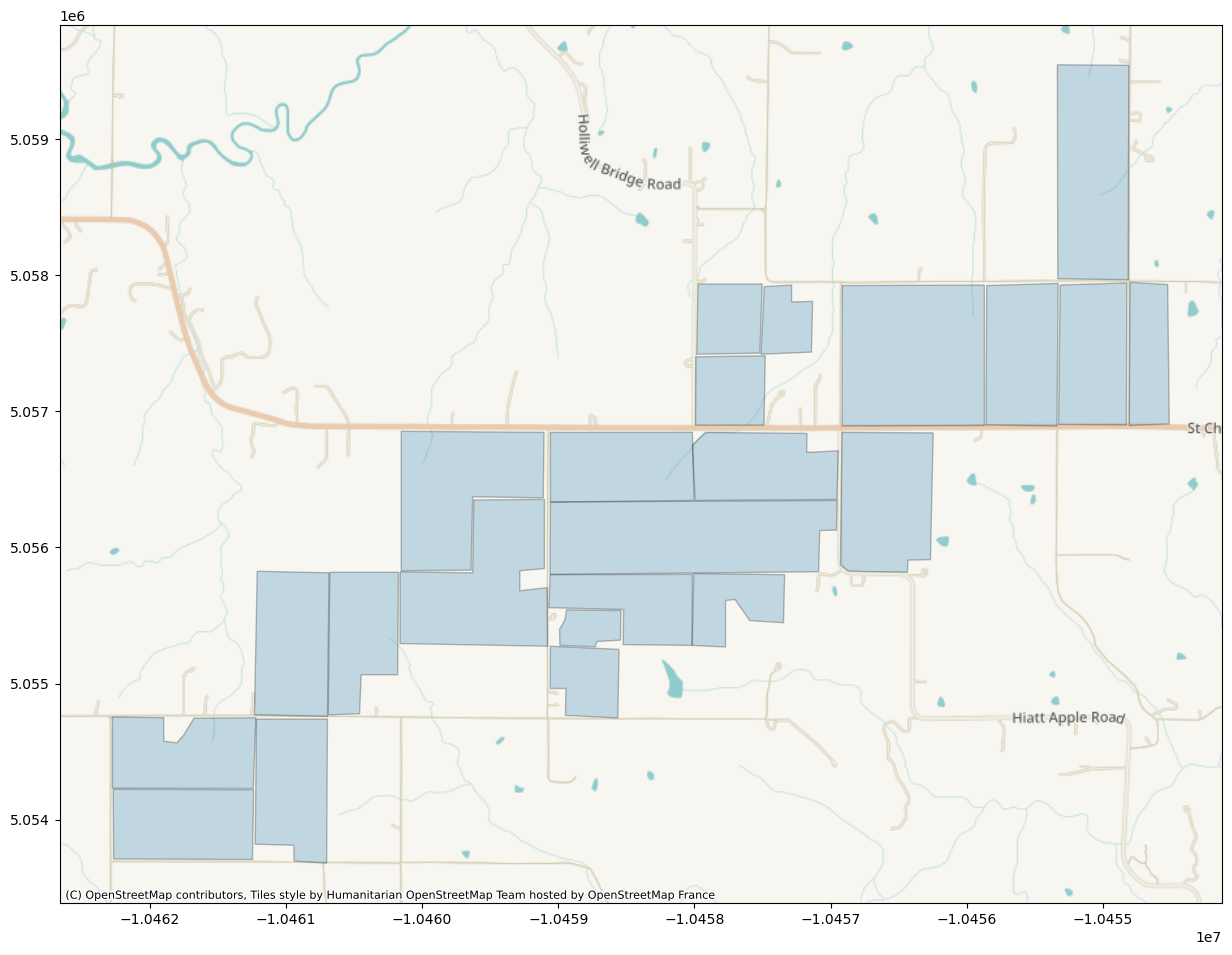

In [16]:
# Read the Nebraska fields into a GeoDataFrame
fields_gdf = gpd.read_file(nebraska_fields)

# Calculate the area for each geometry and add it as a new column
fields_gdf["area"] = fields_gdf.geometry.area

fields_gdf_wm = fields_gdf.to_crs(epsg=3857)

# Explore the GeoDataFrame, visualizing the 'area' column with a specified colormap
ax = fields_gdf_wm.plot(alpha=0.25, edgecolor="k", figsize = (15,15))
cx.add_basemap(ax)

### The Evalscript

In [42]:
evalscript = """
//VERSION=3
//NDVI

function setup() {
  return {
    input: [{
      bands: [
        "red",
        "nir",
        "dataMask",
        "cloud_mask"
      ]
    }],
    output: [
      { id: "index", bands: 1, sampleType: "FLOAT32" },
      { id: "dataMask", bands: 1 },
    ]
  }
}

function evaluatePixel(samples) {
  let ndvi = (samples.nir - samples.red) / (samples.nir + samples.red);
  const indexVal = samples.dataMask === 1 ? ndvi : NaN;
  const clear = samples.dataMask * samples.cloud_mask;
  

  return {
    index: [indexVal],
    dataMask: [clear], // change 'samples.dataMask' to 'clear' to mask out cloudy pixels using the 'clear' band
  };
}
"""

### The Request Body

In [43]:
# we reset our configuration to use the default Sentinel Hub services (instead of Creodias)
config = SHConfig("SH_creds")

fields_gdf = gpd.read_file(nebraska_fields)

aggregation=SentinelHubStatistical.aggregation(
        evalscript=evalscript,
        time_interval=('2022-07-15T00:00:00Z', '2022-07-16T23:59:59Z'),
        aggregation_interval='P1D',
        resolution=(0.00003,0.00003),        
    )

input_data = SentinelHubStatistical.input_data(DataCollection.define_byoc('3f605f75-86c4-411a-b4ae-01c896f0e54e'))

ndvi_requests = []

for geo_shape in fields_gdf.geometry.values:
    request = SentinelHubStatistical(
        aggregation=aggregation,
        input_data=[input_data],
        geometry=Geometry(geo_shape, crs=CRS(fields_gdf.crs)),
        config=config,
    )
    ndvi_requests.append(request)

/Users/william.ray/miniconda3/envs/sentinelhub_base/lib/python3.10/site-packages/sentinelhub/constants.py:114: SHUserWarning: sentinelhub-py supports only WGS 84 coordinate reference system with coordinate order lng-lat. Given pyproj.CRS(4326) has coordinate order lat-lng. Be careful to use the correct order of coordinates.
  warnings.warn(message, category=SHUserWarning)


In [44]:
%%time

download_requests = [ndvi_request.download_list[0] for ndvi_request in ndvi_requests]

client = SentinelHubStatisticalDownloadClient(config=config)

ndvi_stats = client.download(download_requests)

len(ndvi_stats)

CPU times: user 171 ms, sys: 65.1 ms, total: 236 ms
Wall time: 8.31 s


23

### Manipulation and Visualisation of our Output

In [45]:
# Convert the statistics to DataFrames and assign the 'id' column
ndvi_dfs = [
    stats_to_df(polygon_stats).assign(id=id) 
    for polygon_stats, id in zip(ndvi_stats, fields_gdf["id"].values)
]

# Concatenate all DataFrames into a single DataFrame
ndvi_df = pd.concat(ndvi_dfs)

# Display the resulting DataFrame
ndvi_df

,interval_from,interval_to,index_B0_min,index_B0_max,index_B0_mean,index_B0_stDev,index_B0_sampleCount,index_B0_noDataCount,id
0,2022-07-15,2022-07-16,0.292047,0.923180,0.872635,0.055609,78975,22515,1
0,2022-07-15,2022-07-16,0.354765,0.851638,0.734692,0.031858,36340,427,2
0,2022-07-15,2022-07-16,0.543731,0.922417,0.876656,0.031681,77104,4470,3
0,2022-07-15,2022-07-16,0.402968,0.822917,0.712954,0.055666,47124,2105,4
0,2022-07-15,2022-07-16,0.320804,0.936286,0.890258,0.058202,39360,1200,5
0,2022-07-15,2022-07-16,0.601988,0.913462,0.796954,0.040359,72220,19282,6
0,2022-07-15,2022-07-16,0.587116,0.869458,0.765697,0.044020,35844,98,7
0,2022-07-15,2022-07-16,0.433844,0.869024,0.759679,0.034447,37842,2924,8
0,2022-07-15,2022-07-16,0.519101,0.792276,0.678197,0.042181,36344,5891,9
0,2022-07-15,2022-07-16,0.526294,0.773905,0.655293,0.027453,18088,2296,10


In the below cell, we convert the mean NDVI column into a list and then insert it in the pandas geodataframe we created earlier. We can then visualise mean NDVI using this column and an appropriate color map.

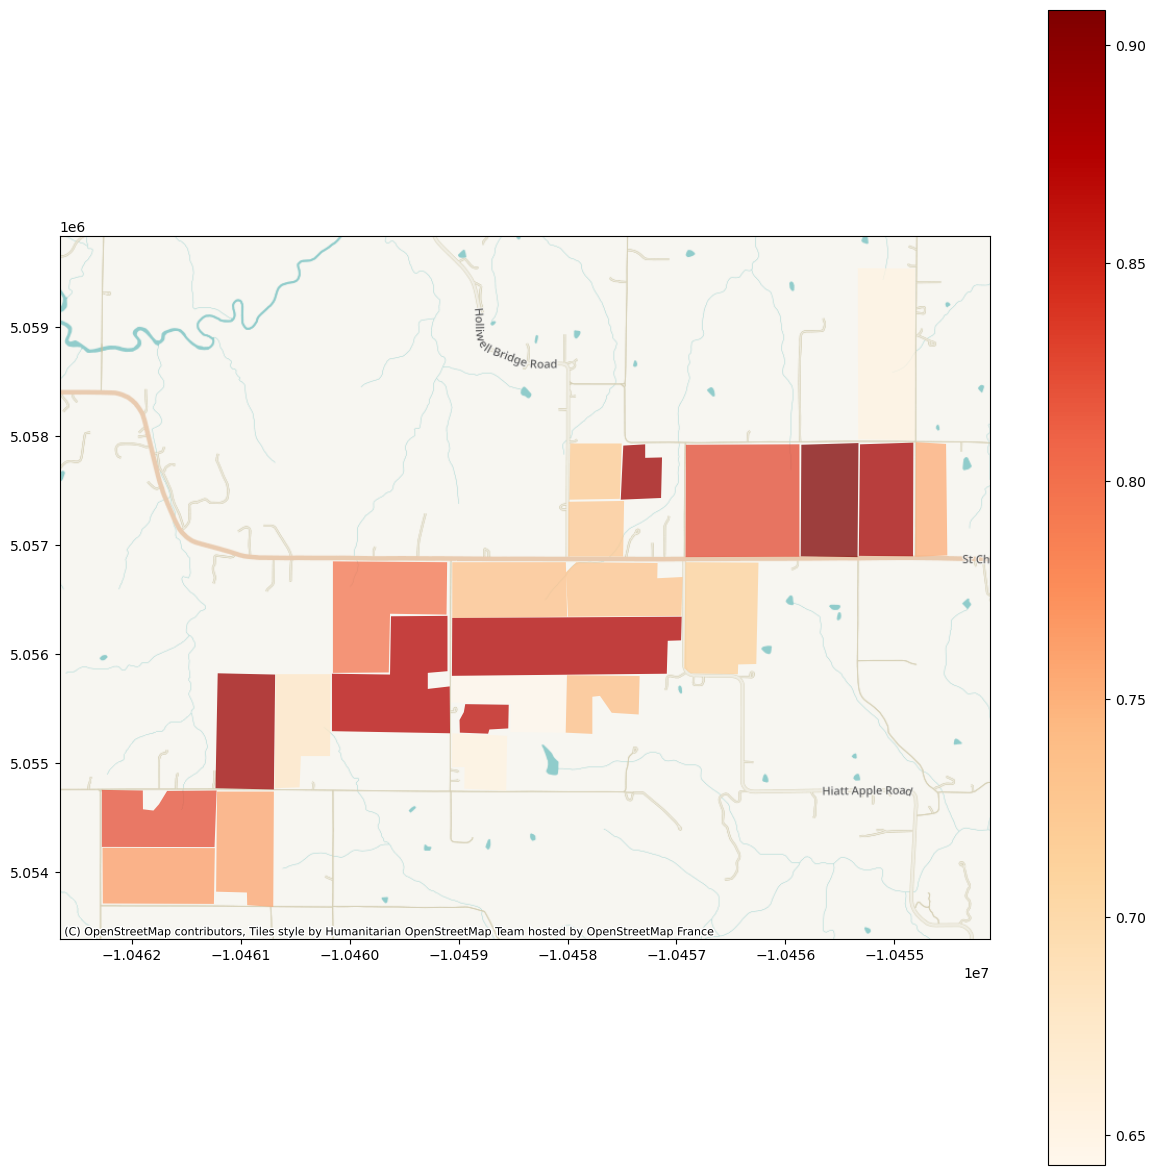

In [46]:
# Extract the mean NDVI values from the DataFrame and convert to a list
mean_ndvi = ndvi_df['index_B0_mean'].tolist()

# Insert the mean NDVI values into the GeoDataFrame as a new column
fields_gdf.insert(1, "mean_ndvi", mean_ndvi)

# Explore the GeoDataFrame, visualizing the 'mean_ndvi' column with a specified colormap

fields_gdf_wm = fields_gdf.to_crs(epsg=3857)
ax = fields_gdf_wm.plot(column='mean_ndvi', cmap='OrRd', legend=True, alpha=0.75, figsize=(15,15))
cx.add_basemap(ax)

## Summary

Congratulations on completing the notebook! From this notebook you should have learned how to:

- Plot a spectral signature plot for a field of interest.
- Create a histogram and box plot for a certain band.
- Plot and style multiple box plots to compare land cover types.
- Create a scatter plot comparing two spectral bands.
- Create waffle charts of categorical datasets.
- Create choropleth maps based on your inputs and outputs.

After running these examples you are now ready to go out there and start to really analyse your data whether from Statistical or Processing APIs!